# Fertility Contagion Model using AgentPy

An agent-based model that simulates the propagation of a disease through a network.

In [1115]:
# Import libraries.

# Data preprocessing.
import pandas as pd
from scipy import interpolate, signal
import statsmodels.api as sm
import bottleneck as bn
from sklearn.impute import KNNImputer

# Model design.
import agentpy as ap
import networkx as nx
import numpy as np
import random

# Visualization.
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

## Data Preprocessing

Get numerical values from Pairfam dataset.

In [942]:
# Load data from CSV.
pf_1 = pd.read_csv("../data/processed/fert_anchor_1.csv")
pf_2 = pd.read_csv("../data/processed/fert_anchor_2.csv")
pf_3 = pd.read_csv("../data/processed/fert_anchor_3.csv")
pf_4 = pd.read_csv("../data/processed/fert_anchor_4.csv")
pf_5 = pd.read_csv("../data/processed/fert_anchor_5.csv")
pf_6 = pd.read_csv("../data/processed/fert_anchor_6.csv")
pf_7 = pd.read_csv("../data/processed/fert_anchor_7.csv")
pf_8 = pd.read_csv("../data/processed/fert_anchor_8.csv")

In [853]:
def filter_rel(df):

    # Filter out respondents without partners.
    df = df.dropna(subset="pid")

    # Filter out respondents without relationship status.
    df = df.dropna(subset="relstat")

    # Filter out anchors without cohabitation.
    # df = df[df["relstat"].str.contains("COHAB")]

    # Filter out anchors who are homosexual or are infertile.
    df = df[df["homosex_new"] == "0 Hetero"]
    df = df[df["infertile"] == "0 Fertile"]

    return df

In [945]:
def scale_items_5(df):
    """ Scale questions with 5 items scale. """

    # Change all values to strings.
    df = df.astype(str)

    # Get the first character in the string (the numerical value of the response).
    df = df.apply(lambda x: x.str[0])

    # Replace nan and 7 with NaN.
    df = df.replace({"7": np.nan, "n": np.nan})

    # Covert columns to float.
    df = df.astype("float")

    # Normalize values.
    df = df.apply(lambda x: (x - 1) / 4)

    return df

In [855]:
def convert_items_num(df):
    """ Convert responses to numeric. """

    # Change all values to strings.
    df = df.astype(str)

    # Get the first character in the string (the numerical value of the response).
    df = df.apply(lambda x: x.str[0])

    # Replace nan and 7 with NaN
    df = df.replace({"n": np.nan})

    # Covert columns to float.
    df = df.astype("float")

    return df

In [937]:
def create_value_children(df):

    # Transform variables to integer.
    colnames_1 = [
        "bce2i1",
        "bce2i5",
        "bce2i2",
        "bce2i3",
        "bce2i4"
    ]

    colnames_2 = [
        "bce2i6",
        "bce2i8",
        "bce2i7",
        "bce2i9",
        "bce2i10"
    ]

    df[colnames_1 + colnames_2] = scale_items_5(df[colnames_1 + colnames_2])

    # Value of Children.
    value_children_positive = df[colnames_1].mean(axis = 1)

    value_children_negative = df[colnames_2].mean(axis = 1)

    df["value_children"] = (value_children_positive - value_children_negative).apply(lambda x: round(x, 2))

    return df

In [857]:
def create_social_pressure(df):

    # Transform variables to integer.
    colnames_1 = [
        "frt10i1",
        "frt10i2"
    ]

    colnames_2 = [
        "frt10i3",
        "frt10i4"
    ]

    df[colnames_1 + colnames_2] = scale_items_5(df[colnames_1 + colnames_2])

    # Social pressure (p).
    social_pressure_positive = df[colnames_1].mean(axis = 1)

    social_pressure_negative = df[colnames_2].mean(axis = 1)

    df["social_pressure"] = (social_pressure_positive - social_pressure_negative).apply(lambda x: round(x, 2))

    return df

In [858]:
def create_social_support(df):

    # Transform variables to integer.
    colnames = [
        "frt20i1",
        "frt20i2",
        "frt20i3"
    ]

    df[colnames] = scale_items_5(df[colnames])

    # Social support (s).
    social_support = df[colnames].mean(axis = 1)

    df["social_support"] = social_support.apply(lambda x: round(x, 2))

    return df

In [859]:
def create_emotional_autonomy(df):

    # Transform variables to integer.
    colnames = [
        "per1i1",
        "per1i5",
        "per1i10"
    ]

    df[colnames] = scale_items_5(df[colnames])

    # Emotional autonomy.
    emotional_autonomy_rev = df[colnames].mean(axis = 1)

    df["emotional_autonomy"] = (1 - emotional_autonomy_rev).apply(lambda x: round(x, 2))

    return df

In [909]:
def create_births(df1, df2):
    """Create a binary variable measuring births from one wave to another. """

    ref = df1[df1["id"].isin(df2["id"])].sort_values(by = ["id"])
    diff = df2[df2["id"].isin(ref["id"])].sort_values(by = ["id"])
    ref["birth"] = diff["nkidsbio"].values - ref["nkidsbio"].values
    ref["birth"] = ref["birth"].apply(lambda x: 1 if x>0 else 0)

    return ref

In [861]:
def select_age(df):
    """ Select age according to sex (always the mother). """
    
    df.loc[(df["sex_gen"] == 1) & (df["page"].isnull().apply(lambda x: not x)), "age"] = df.loc[df["sex_gen"] == 1, "page"]

    return df

In [862]:
def rolling_ratio_age(df, age, width, nkids = None):
    """ Calculate ratios of birth for conditional probability. """

    df_age = df[(df["age"] >= (age - width)) & (df["age"] <= (age + width))]

    if nkids:
        if nkids < 3:
            df_age_nkids = df_age[df_age["nkidsbio"] == nkids]
        else:
            df_age_nkids = df_age[df_age["nkidsbio"] >= nkids]
    else:
        df_age_nkids = df_age
        
    # Probability of certain nkids and age.
    prob_B = df_age_nkids.shape[0] / df.shape[0]
    
    # Probability of certain nkids and age and new child.
    prob_A_and_B = df_age_nkids[df_age_nkids["birth"] == 1].shape[0] / df.shape[0]
    
    # Conditional probability.
    if prob_B == 0 or df_age_nkids.shape[0] < 10:
        ratio = 0
    else:
        ratio = prob_A_and_B / prob_B
    
    return ratio

In [863]:
def rolling_ratio_voc(df, voc, width):
    """ Calculate ratios of birth for conditional probability. """

    df_voc = df[(df["value_children"] >= (voc - width)) & (df["value_children"] <= (voc + width))]
        
    # Probability of certain nkids and age.
    prob_B = df_voc.shape[0] / df.shape[0]
    
    # Probability of certain nkids and age and new child.
    prob_A_and_B = df_voc[df_voc["birth"] == 1].shape[0] / df.shape[0]
    
    # Conditional probability.
    if prob_B == 0 or df_voc.shape[0] < 10:
        ratio = 0
    else:
        ratio = prob_A_and_B / prob_B
    
    return ratio

In [976]:
# Filter out respondents without partners.
agents_1 = filter_rel(pf_1)
agents_2 = filter_rel(pf_2)
agents_3 = filter_rel(pf_3)
agents_4 = filter_rel(pf_4)
agents_5 = filter_rel(pf_5)
agents_6 = filter_rel(pf_6)
agents_7 = filter_rel(pf_7)
agents_8 = filter_rel(pf_8)

In [946]:
# Create new variables for simulation.
agents_1 = create_value_children(agents_1)
agents_1 = create_emotional_autonomy(agents_1)

agents_2 = create_value_children(agents_2)
agents_2 = create_social_pressure(agents_2)
agents_2 = create_social_support(agents_2)

agents_4 = create_value_children(agents_4)
agents_4 = create_social_pressure(agents_4)
agents_4 = create_social_support(agents_4)

agents_5 = create_emotional_autonomy(agents_5)

agents_6 = create_value_children(agents_6)
agents_6 = create_social_pressure(agents_6)
agents_6 = create_social_support(agents_6)

agents_8 = create_value_children(agents_8)
agents_8 = create_social_pressure(agents_8)
agents_8 = create_social_support(agents_8)

In [866]:
# Get only interesting variables for simulation.
vars_gen = [
    "id", 
    "pid", 
    "wave",
    "age", 
    "page", 
    "sex_gen",
    "psex_gen",
    "nkidsbio", 
]

agents_1 = agents_1[vars_gen + ["value_children", "emotional_autonomy"]]
agents_2 = agents_2[vars_gen + ["value_children", "social_pressure", "social_support"]]
agents_3 = agents_3[vars_gen]
agents_4 = agents_4[vars_gen + ["value_children", "social_pressure", "social_support"]]
agents_5 = agents_5[vars_gen + ["emotional_autonomy"]]
agents_6 = agents_6[vars_gen + ["value_children", "social_pressure", "social_support"]]
agents_7 = agents_7[vars_gen]
agents_8 = agents_8[vars_gen + ["value_children", "social_pressure", "social_support"]]

In [867]:
# Change columns to numeric.
cols = ["wave", "sex_gen", "psex_gen"]

agents_1[cols] = convert_items_num(agents_1[cols])
agents_2[cols] = convert_items_num(agents_2[cols])
agents_3[cols] = convert_items_num(agents_3[cols])
agents_4[cols] = convert_items_num(agents_4[cols])
agents_5[cols] = convert_items_num(agents_5[cols])
agents_6[cols] = convert_items_num(agents_6[cols])
agents_7[cols] = convert_items_num(agents_7[cols])
agents_8[cols] = convert_items_num(agents_8[cols])

In [868]:
# Create births for all years.
diff_1 = create_births(agents_1, agents_2)
diff_2 = create_births(agents_2, agents_3)
diff_3 = create_births(agents_3, agents_4)
diff_4 = create_births(agents_4, agents_5)
diff_5 = create_births(agents_5, agents_6)
diff_6 = create_births(agents_6, agents_7)
diff_7 = create_births(agents_7, agents_8)

In [871]:
# Calculate P(child | age, num_children) 

# Create dataframes per wave change.
age_child_1 = select_age(diff_1)[["age", "nkidsbio", "birth"]].reset_index(drop = True)
age_child_2 = select_age(diff_2)[["age", "nkidsbio", "birth"]].reset_index(drop = True)
age_child_3 = select_age(diff_3)[["age", "nkidsbio", "birth"]].reset_index(drop = True)
age_child_4 = select_age(diff_4)[["age", "nkidsbio", "birth"]].reset_index(drop = True)
age_child_5 = select_age(diff_5)[["age", "nkidsbio", "birth"]].reset_index(drop = True)
age_child_6 = select_age(diff_6)[["age", "nkidsbio", "birth"]].reset_index(drop = True)
age_child_7 = select_age(diff_7)[["age", "nkidsbio", "birth"]].reset_index(drop = True)

# Concatenate dataframes.
age_child_total = pd.concat([age_child_1, age_child_2])
age_child_total = pd.concat([age_child_total, age_child_3])
age_child_total = pd.concat([age_child_total, age_child_4])
age_child_total = pd.concat([age_child_total, age_child_5])
age_child_total = pd.concat([age_child_total, age_child_6])
age_child_total = pd.concat([age_child_total, age_child_7])

In [872]:
age_list = []
ratio_list = []
ratio_list_0 = []
ratio_list_1 = []
ratio_list_2 = []
ratio_list_3 = []

for age in list(range(int(age_child_total["age"].min()) - 5, int(age_child_total["age"].min()))):
    age_list.append(age)
    ratio_list.append(0)
    ratio_list_0.append(0)
    ratio_list_1.append(0)
    ratio_list_2.append(0)
    ratio_list_3.append(0)

for age in list(range(int(age_child_total["age"].min()), int(age_child_total["age"].max() + 1), 1)):
    age_list.append(age)
    ratio_list.append(rolling_ratio_age(age_child_total, age, 2))
    ratio_list_0.append(rolling_ratio_age(age_child_total, age, 2, 0))
    ratio_list_1.append(rolling_ratio_age(age_child_total, age, 2, 1))
    ratio_list_2.append(rolling_ratio_age(age_child_total, age, 2, 2))
    ratio_list_3.append(rolling_ratio_age(age_child_total, age, 2, 3))

In [ ]:
# Create Empirical Probability Distributions.
# https://machinelearningmastery.com/empirical-distribution-function-in-python/

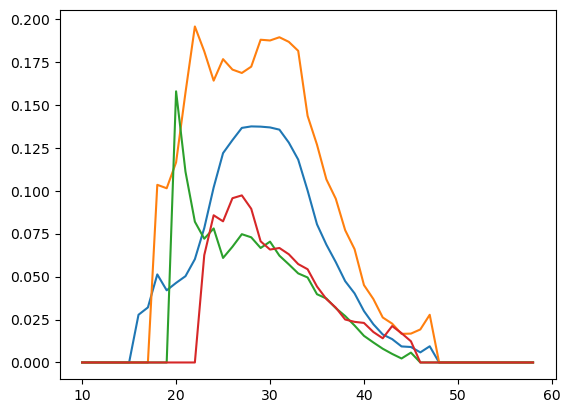

In [873]:
plt.plot(age_list, ratio_list_0)
plt.plot(age_list, ratio_list_1)
plt.plot(age_list, ratio_list_2)
plt.plot(age_list, ratio_list_3)

In [874]:
# Quadratic interpolation of the curves.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d

age_obs = np.array(age_list)
age_inter = np.linspace(age_obs.min(), age_obs.max(), num = 10000)

ratio_obs_0 = np.array(ratio_list_0)
inter_0 = interpolate.interp1d(age_obs, ratio_obs_0, kind = "nearest")

ratio_obs_1 = np.array(ratio_list_1)
inter_1 = interpolate.interp1d(age_obs, ratio_obs_1, kind = "nearest")

ratio_obs_2 = np.array(ratio_list_2)
inter_2 = interpolate.interp1d(age_obs, ratio_obs_2, kind = "nearest")

ratio_obs_3 = np.array(ratio_list_3)
inter_3 = interpolate.interp1d(age_obs, ratio_obs_3, kind = "nearest")

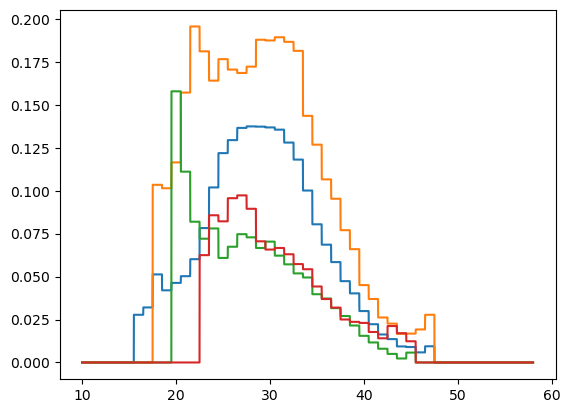

In [875]:
plt.plot(age_inter, inter_0(age_inter))
plt.plot(age_inter, inter_1(age_inter))
plt.plot(age_inter, inter_2(age_inter))
plt.plot(age_inter, inter_3(age_inter))

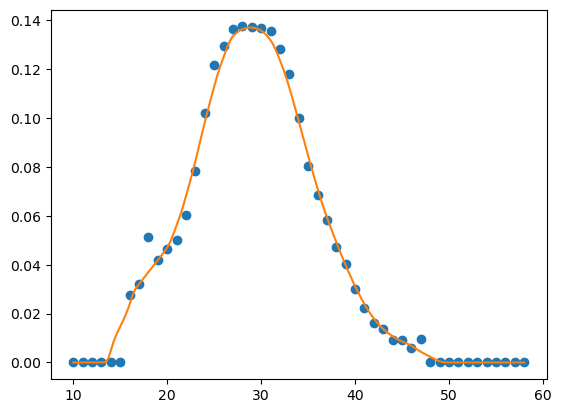

In [876]:
# LOWESS smoother (locally weighted scatterplot smoothing). Local regression method.
# https://www.statsmodels.org/dev/examples/notebooks/generated/lowess.html#LOWESS-Smoother

lowess_0 = sm.nonparametric.lowess(inter_0(age_inter), age_inter, frac = 0.12)
lowess_0 = interpolate.interp1d(lowess_0[:, 0], lowess_0[:, 1], kind = "slinear")

plt.plot(age_obs, ratio_obs_0, "o", label="observation")
plt.plot(age_inter, lowess_0(age_inter))

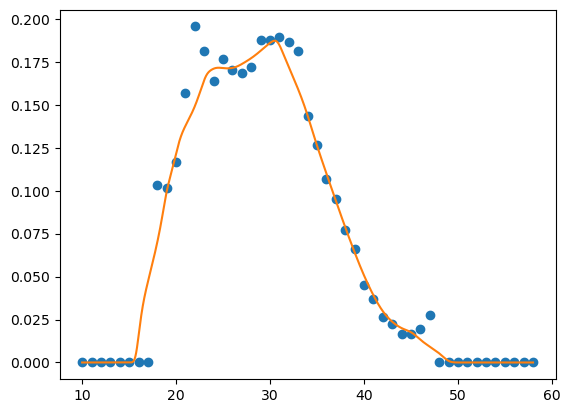

In [877]:
# LOWESS smoother (locally weighted scatterplot smoothing). Local regression method.
lowess_1 = sm.nonparametric.lowess(inter_1(age_inter), age_inter, frac = 0.15)
lowess_1 = interpolate.interp1d(lowess_1[:, 0], lowess_1[:, 1], kind = "slinear")

plt.plot(age_obs, ratio_obs_1, "o", label="observation")
plt.plot(age_inter, lowess_1(age_inter))

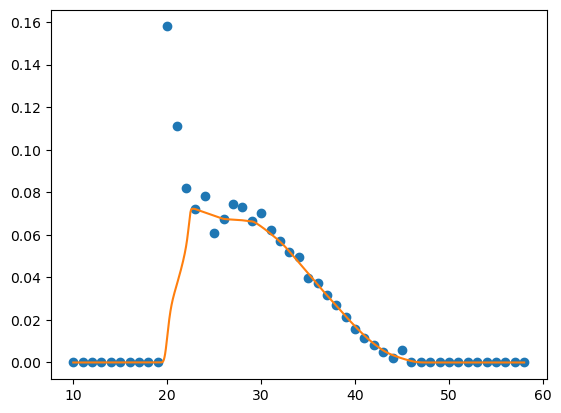

In [878]:
# LOWESS smoother (locally weighted scatterplot smoothing). Local regression method.
lowess_2 = sm.nonparametric.lowess(inter_2(age_inter), age_inter, frac = 0.135)
lowess_2 = interpolate.interp1d(lowess_2[:, 0], lowess_2[:, 1], kind = "slinear")

plt.plot(age_obs, ratio_obs_2, "o", label="observation")
plt.plot(age_inter, lowess_2(age_inter))

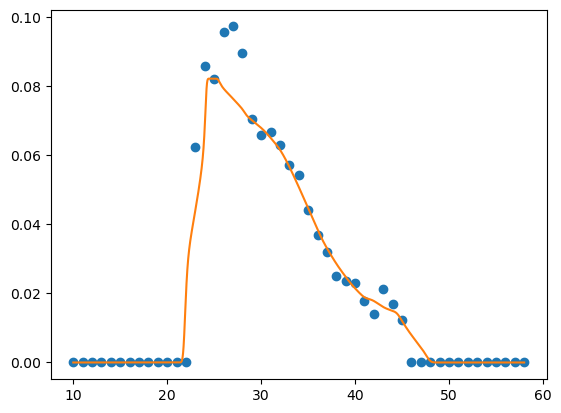

In [879]:
# LOWESS smoother (locally weighted scatterplot smoothing). Local regression method.
lowess_3 = sm.nonparametric.lowess(inter_3(age_inter), age_inter, frac = 0.14)
lowess_3 = interpolate.interp1d(lowess_3[:, 0], lowess_3[:, 1], kind = "slinear")

plt.plot(age_obs, ratio_obs_3, "o", label="observation")
plt.plot(age_inter, lowess_3(age_inter))

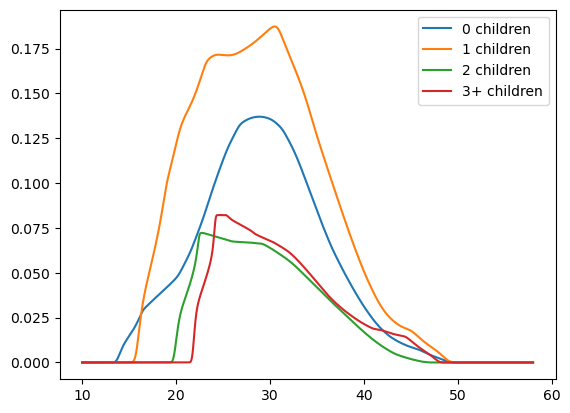

In [880]:
plt.plot(age_inter, lowess_0(age_inter), label = "0 children")
plt.plot(age_inter, lowess_1(age_inter), label = "1 children")
plt.plot(age_inter, lowess_2(age_inter), label = "2 children")
plt.plot(age_inter, lowess_3(age_inter), label = "3+ children")
plt.legend()

In [881]:
# Calculate P(child | VoC) 

# Create dataframes per wave change.
voc_1 = diff_1[["value_children", "birth"]].reset_index(drop = True)
voc_2 = diff_2[["value_children", "birth"]].reset_index(drop = True)
voc_4 = diff_4[["value_children", "birth"]].reset_index(drop = True)
voc_6 = diff_6[["value_children", "birth"]].reset_index(drop = True)

# Concatenate dataframes.
voc_total = pd.concat([voc_1, voc_2])
voc_total = pd.concat([voc_total, voc_4])
voc_total = pd.concat([voc_total, voc_6])

In [882]:
voc_list = []
ratio_voc_list = []

for voc in np.linspace(voc_total["value_children"].min(), voc_total["value_children"].max(), 201):
    voc_list.append(voc)
    ratio_voc_list.append(rolling_ratio_voc(voc_total, voc, 0.15))

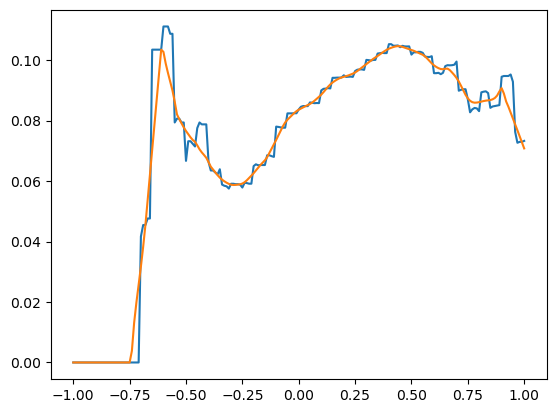

In [883]:
plt.plot(voc_list, ratio_voc_list)

# LOWESS smoother (locally weighted scatterplot smoothing). Local regression method.
lowess_voc = sm.nonparametric.lowess(ratio_voc_list, voc_list, frac = 0.075)
lowess_voc = interpolate.interp1d(lowess_voc[:, 0], lowess_voc[:, 1], kind = "slinear")

plt.plot(voc_list, lowess_voc(voc_list))

In [1159]:
# Filter out respondents without partners.
agents_1 = filter_rel(pf_1)
agents_2 = pf_2
agents_3 = pf_3
agents_4 = pf_4
agents_5 = pf_5
agents_6 = pf_6
agents_7 = pf_7
agents_8 = pf_8

In [1160]:
# Get only those anchors that continue with same partner in wave 8 from wave 1.
agents_1 = agents_1[agents_1["pid"].isin(agents_8["pid"])]
agents_2 = agents_2[agents_2["id"].isin(agents_1["id"])]
agents_3 = agents_3[agents_3["id"].isin(agents_1["id"])]
agents_4 = agents_4[agents_4["id"].isin(agents_1["id"])]
agents_5 = agents_5[agents_5["id"].isin(agents_1["id"])]
agents_6 = agents_6[agents_6["id"].isin(agents_1["id"])]
agents_7 = agents_7[agents_7["id"].isin(agents_1["id"])]
agents_8 = agents_8[agents_8["id"].isin(agents_1["id"])]

In [1161]:
# Set of IDs present in all waves. 
id_1 = set(agents_1["id"])
id_2 = set(agents_2["id"])
id_3 = set(agents_3["id"])
id_4 = set(agents_4["id"])
id_5 = set(agents_5["id"])
id_6 = set(agents_6["id"])
id_7 = set(agents_7["id"])
id_8 = set(agents_8["id"])
id_inter = id_1.intersection(id_2, id_3, id_4, id_5, id_6, id_7, id_8)

In [1162]:
# Get only those anchors that continue with same partner in wave 8 from wave 1.
agents_1 = agents_1[agents_1["id"].isin(id_inter)]
agents_2 = agents_2[agents_2["id"].isin(id_inter)]
agents_3 = agents_3[agents_3["id"].isin(id_inter)]
agents_4 = agents_4[agents_4["id"].isin(id_inter)]
agents_5 = agents_5[agents_5["id"].isin(id_inter)]
agents_6 = agents_6[agents_6["id"].isin(id_inter)]
agents_7 = agents_7[agents_7["id"].isin(id_inter)]
agents_8 = agents_8[agents_8["id"].isin(id_inter)]

In [1163]:
# Create new variables for simulation.
agents_1 = create_value_children(agents_1)
agents_1 = create_emotional_autonomy(agents_1)

agents_2 = create_value_children(agents_2)
agents_2 = create_social_pressure(agents_2)
agents_2 = create_social_support(agents_2)

agents_4 = create_value_children(agents_4)
agents_4 = create_social_pressure(agents_4)
agents_4 = create_social_support(agents_4)

agents_5 = create_emotional_autonomy(agents_5)

agents_6 = create_value_children(agents_6)
agents_6 = create_social_pressure(agents_6)
agents_6 = create_social_support(agents_6)

agents_8 = create_value_children(agents_8)

In [1164]:
# Get only interesting variables for simulation.
vars_gen = [
    "id", 
    "pid", 
    "wave",
    "age", 
    "page", 
    "sex_gen",
    "psex_gen",
    "nkidsbio", 
]

agents_1 = agents_1[vars_gen + ["value_children", "emotional_autonomy"]]
agents_2 = agents_2[vars_gen + ["value_children", "social_pressure", "social_support"]]
agents_3 = agents_3[vars_gen]
agents_4 = agents_4[vars_gen + ["value_children", "social_pressure", "social_support"]]
agents_5 = agents_5[vars_gen + ["emotional_autonomy"]]
agents_6 = agents_6[vars_gen + ["value_children", "social_pressure", "social_support"]]
agents_7 = agents_7[vars_gen]
agents_8 = agents_8[vars_gen + ["value_children"]]

In [1165]:
# Change columns to numeric.
cols = ["wave", "sex_gen", "psex_gen"]

agents_1[cols] = convert_items_num(agents_1[cols])
agents_2[cols] = convert_items_num(agents_2[cols])
agents_3[cols] = convert_items_num(agents_3[cols])
agents_4[cols] = convert_items_num(agents_4[cols])
agents_5[cols] = convert_items_num(agents_5[cols])
agents_6[cols] = convert_items_num(agents_6[cols])
agents_7[cols] = convert_items_num(agents_7[cols])
agents_8[cols] = convert_items_num(agents_8[cols])

In [1210]:
# Initial set of agents.
agents_initial = agents_1.copy()
agents_initial["social_pressure"] = agents_2["social_pressure"].values
agents_initial["social_support"] = agents_2["social_support"].values
agents_initial = agents_initial.iloc[agents_initial.isnull().sum(axis=1).argsort()][1:1301]

In [1211]:
# KNN imputation of missing values.
# https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

# Define KNN model.
imputer = KNNImputer(
    n_neighbors = 5,
    weights = "uniform",
    metric = "nan_euclidean"
)

# Fit on data.
imputer.fit(agents_initial.drop(["id", "pid", "wave"], axis = 1))

# Replace data.
imputer.set_output(transform = "pandas")
agents_impute = imputer.transform(agents_initial.drop(["id", "pid", "wave"], axis = 1))

# Make sure Int variables stay that way.
agents_impute["age"] = agents_impute["age"].apply(lambda x: int(round(x, 0)))
agents_impute["page"] = agents_impute["page"].apply(lambda x: int(round(x, 0)))
agents_impute["sex_gen"] = agents_impute["sex_gen"].apply(lambda x: int(round(x, 0)))
agents_impute["psex_gen"] = agents_impute["psex_gen"].apply(lambda x: int(round(x, 0)))
agents_impute["num_kids"] = agents_impute["nkidsbio"].apply(lambda x: int(round(x, 0)))

# Round to 2 decimals.
agents_impute["social_pressure"] = agents_impute["social_pressure"].apply(lambda x: round(x, 2))
agents_impute["social_support"] = agents_impute["social_support"].apply(lambda x: round(x, 2))

# Replace old NaN values with imputed ones.
agents_initial[list(agents_impute.columns)] = agents_impute

In [1212]:
# Focus on the initial agents
agents_1 = agents_1[agents_1["id"].isin(agents_initial["id"])]
agents_2 = agents_2[agents_2["id"].isin(agents_initial["id"])]
agents_3 = agents_3[agents_3["id"].isin(agents_initial["id"])]
agents_4 = agents_4[agents_4["id"].isin(agents_initial["id"])]
agents_5 = agents_5[agents_5["id"].isin(agents_initial["id"])]
agents_6 = agents_6[agents_6["id"].isin(agents_initial["id"])]
agents_7 = agents_7[agents_7["id"].isin(agents_initial["id"])]
agents_8 = agents_8[agents_8["id"].isin(agents_initial["id"])]

In [1213]:
# Create births for all years.
diff_1 = create_births(agents_1, agents_2)
diff_2 = create_births(agents_2, agents_3)
diff_3 = create_births(agents_3, agents_4)
diff_4 = create_births(agents_4, agents_5)
diff_5 = create_births(agents_5, agents_6)
diff_6 = create_births(agents_6, agents_7)
diff_7 = create_births(agents_7, agents_8)

In [1214]:
# Count number of births after each wave.
births_per_wave = pd.DataFrame({
    "wave": [1, 2, 3, 4, 5, 6, 7], 
    "births": [
        diff_1["birth"].sum(),
        diff_2["birth"].sum(),
        diff_3["birth"].sum(),
        diff_4["birth"].sum(),
        diff_5["birth"].sum(),
        diff_6["birth"].sum(),
        diff_7["birth"].sum()
    ]
})

births_per_wave

,wave,births
0,1,141
1,2,130
2,3,120
3,4,111
4,5,111
5,6,104
6,7,72


In [1215]:
# Select the woman's age in all cases.
agents_initial = select_age(agents_initial)

# Set social pressure as binary.
agents_initial["social_pressure"] = agents_initial["social_pressure"].apply(lambda x: 1 if x > 0 else -1)

In [1216]:
# Get only the necessary variables.
agents_params = agents_initial.drop(["id", "pid", "wave", "page", "sex_gen", "psex_gen", "nkidsbio"], axis = 1).reset_index(drop = True)

# Save to CSV.
agents_params.to_csv("../data/processed/fert_agents_params.csv", index = False)

<Axes: >

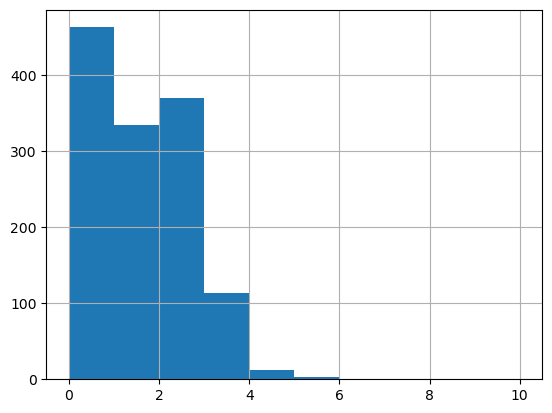

In [1218]:
agents_params["num_kids"].hist()

## Model Definition

We define a new agent type called `Couple` by creating a subclass of `Agent`.

In [128]:
class Couple(ap.Agent): 

    def setup(self, VoC):
        """ Initialize a new variable at agent creation. """

        self.VoC = VoC

In [143]:
class FertModel(ap.Model):
    """ A simple fertility contagion model. """

    def setup(self):

        print(self.p.VoC)
        print(self.p.agents)

        self.agents = ap.AgentList(
            model = self, 
            objs = self.p.agents, 
            cls = Couple, 
            VoC = ap.AttrIter(self.p.VoC)
        )

    def step(self):

        None

    def update(self):

        None
        self.record("Mean Value", np.mean(np.array(self.agents.VoC)))

    def end(self):

        self.agents.record("VoC")

In [144]:
value_list =  [1,2,3,4,5]
type(value_list)

list

In [145]:
np.mean(np.array(value_list))

3.0

In [146]:
parameters = {
    "agents": 5,
    "steps": 5,
    "seed": 42,
    "VoC": value_list
}

model = FertModel(parameters)
results = model.run()

[1, 2, 3, 4, 5]
5
Completed: 5 steps
Run time: 0:00:00.002989
Simulation finished


In [147]:
results

DataDict {
'info': Dictionary with 9 keys
'parameters': 
    'constants': Dictionary with 4 keys
'variables': 
    'FertModel': DataFrame with 1 variable and 6 rows
    'Couple': DataFrame with 1 variable and 5 rows
'reporters': DataFrame with 1 variable and 1 row
}

In [148]:
results.variables.Couple

,,VoC
obj_id,t,
1,5,1
2,5,2
3,5,3
4,5,4
5,5,5


In [149]:
results.variables.FertModel

,Mean Value
t,
0,3.0
1,3.0
2,3.0
3,3.0
4,3.0
5,3.0
